In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

### 1. Data Preparation

In this section, the cleaned dataset in csv format is read into pandas. The geojson shape files are also read into geopandas. A specific region is selected and multiple arrays are created in numpy to benefit from vectorisation. The datasets are split into primary and secondary enrollment and location (lat/lon) data - i.e. 4 arrays in total. 


In [2]:
# read in the prepared dataset. Evaluate point data to make it readible by geopandas
df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})

In [3]:
# Filter to only one region, and read in geojson file.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'
gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
# limit geojson to only selected region
gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
# limit clean dataset to only selected region
df = df.loc[df['region'] == region]

In [4]:
df['gr_offer'].value_counts()

G.1-8      23
G.1-4      16
G. 9-12     2
Name: gr_offer, dtype: int64

In [5]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy()
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc])
df_sec_loc = np.array([np.array(i) for i in df_sec_loc])

### 2. Create helper functions

##### 1. Shape Function. 
This function estimates the secondary level enrollment based on how close the primary school is to the secondary school. If the school is within 2km, an estimated 30 minutes for children, the full enrollment is possible. Therefore full enrollment is returned. If enrollment is greater than 5km, then zero enrollment is expected as it is a walk of 75 minutes each way. The school is too far and low enrollment is expected. Between 2km-5km, a minmax scaling is used to aassume a linear dropoff in enrollment.

Assumption here is : 
1km represents approximately 15 minutes’ walk for children, 2km: 30mins, 3km: 45 mins etc. (SRJIE ARTICLE)

In [6]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    return np.rint(np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            ))

##### 2. Check Region Function. 

A function that takes as input a vector of [lat,lon] points and checks to see if it's within the region being proposed. This is necessary because CMA will propose solutions within a box boundary and some of the locations will not be within the region. Since the solutions proposed are at a regional basis, this is a necessary operation.


In [7]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

##### 3. Expected Enrollment Function

This function estimates the enrollment by calculating the distance of a proposed solution of new secondary schools to primary schools. If the primary school is within an adequate distance, determined by the shape function, then the enrollment is added to the expected enrollment. 


In [8]:
def expected_enrollment(prim_loc, prim_enroll, x, sec_loc):
    if check_woreda(x):
        # Check if all new locations are within the region, if not penalise with 0 enrollment
        x = np.append(sec_loc, x) # add proposed locations to current list of secondary schools
    #     x = np.array(np.array_split(x, (len(df_sec_loc)+proposed_schools)))
        distance = np.min(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)
        enrollment = df_prim_enroll[np.argmin(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)]
        enrollment = enrollment*.79901 # by enrollment proportion
        expected_enrollment = np.sum(shape(distance,enrollment))
        return expected_enrollment
    else:
        return 0 # penalising all falling outside regional parameters.

#### 4. Objective Function F(x)

In [10]:
# The Objective Function
proposed_schools = 5
def f(x):
    """ The objective function which takes as input a 1d array.Every two elements 
    represent the lat/lon of a point in a given area. A locations variable is created
    which splits the points into pairs. The expected_enrollment function is then run 
    on this (5,2) list to return the total expected enrollment for the five locations.
    """
    locations = np.array(np.array_split(x, proposed_schools))
    test_case = expected_enrollment(df_prim_loc, df_prim_enroll, locations, df_sec_loc)
    return test_case*-1 # inverse of f(x) is needed as looking to maximise


### 3. Prepare CMA

#### 3.1. Create box boundaries

In [11]:
# Establish box boundary for CMA. 
bounds = gdf_woreda_shp.bounds
# bounds = gdf_region_shp.bounds
lat_bounds = bounds[['miny','maxy']].to_numpy()[0]
lon_bounds = bounds[['minx','maxx']].to_numpy()[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
bounds # array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]

array([[10.71371939, 36.68932805],
       [10.96477258, 36.96973029]])

In [12]:
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805, 10.71371939,
        36.68932805, 10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029, 10.96477258,
        36.96973029, 10.96477258, 36.96973029, 10.96477258, 36.96973029])]

#### 3.2. Create starting point for CMA

In [13]:
# Create starting points within regional box boundaries.

def create_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=5)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=5)
    sp = np.vstack((sp1, sp2)).T
    return sp

In [14]:
# create a random starting point within the target region.
def get_random_sp():
    sp = create_random_sp()
    for i in range(0,10000):
        if check_woreda(sp) == True:
            sp = sp.flatten()
            return sp
            break
        else:
            sp = create_random_sp()

In [25]:
get_random_sp()

array([10.93504075, 36.75096457, 10.81847362, 36.8627881 , 10.81442347,
       36.84277664, 10.84747085, 36.81753188, 10.90825482, 36.73283604])

In [26]:
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805, 10.71371939,
        36.68932805, 10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029, 10.96477258,
        36.96973029, 10.96477258, 36.96973029, 10.96477258, 36.96973029])]

#### 3.3. Run CMA

In [30]:
maxits=  100000
es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=0.25,
                          inopts={'bounds': boundsxy,'seed':1234,
                                 'verb_disp': 50})
es.optimize(f, iterations=maxits / es.popsize, min_iterations=1000)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Fri Jun 24 10:07:53 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 0.000000000000000e+00 1.0e+00 2.40e-01  2e-01  2e-01 0:00.0
    2     20 0.000000000000000e+00 1.2e+00 2.30e-01  2e-01  2e-01 0:00.0
    3     30 0.000000000000000e+00 1.3e+00 2.23e-01  2e-01  2e-01 0:00.0
    4     40 0.000000000000000e+00 1.3e+00 2.43e-01  2e-01  3e-01 0:00.1
    5     50 0.000000000000000e+00 1.5e+00 2.47e-01  2e-01  3e-01 0:00.1
    6     60 0.000000000000000e+00 1.5e+00 2.36e-01  2e-01  3e-01 0:00.1
    7     70 0.000000000000000e+00 1.5e+00 2.15e-01  2e-01  2e-01 0:00.1
    8     80 0.000000000000000e+00 1.5e+00 2.17e-01  2e-01  2e-01 0:00.1
    9     90 0.000000000000000e+00 1.5e+00 2.27e-01  2e-01  2e-01 0:00.1
   10    100 0.000000000000000e+00 1.5e+00 2.13e-01  2e-01  2e-01 0:00.1
   11    110 0.000000000000000e+00 1.6e+00 2.08e-01  2e-01  2e-01 0:00.1
   12    120 0.000000000000000e+00 

  111   1110 0.000000000000000e+00 5.1e+00 1.67e-01  1e-01  2e-01 0:01.5
  112   1120 0.000000000000000e+00 5.0e+00 1.68e-01  1e-01  2e-01 0:01.6
  113   1130 0.000000000000000e+00 5.5e+00 1.68e-01  1e-01  2e-01 0:01.6
  114   1140 0.000000000000000e+00 5.6e+00 1.74e-01  1e-01  2e-01 0:01.6
  115   1150 0.000000000000000e+00 5.8e+00 1.81e-01  1e-01  2e-01 0:01.6
  116   1160 0.000000000000000e+00 5.6e+00 1.83e-01  1e-01  2e-01 0:01.6
  117   1170 0.000000000000000e+00 5.6e+00 1.86e-01  1e-01  2e-01 0:01.6
  118   1180 0.000000000000000e+00 5.7e+00 1.78e-01  1e-01  2e-01 0:01.6
  119   1190 0.000000000000000e+00 5.7e+00 1.73e-01  1e-01  2e-01 0:01.6
  120   1200 0.000000000000000e+00 5.7e+00 1.79e-01  1e-01  2e-01 0:01.6
  121   1210 0.000000000000000e+00 5.7e+00 1.77e-01  1e-01  2e-01 0:01.7
  122   1220 0.000000000000000e+00 5.7e+00 1.80e-01  1e-01  2e-01 0:01.7
  123   1230 0.000000000000000e+00 5.6e+00 1.84e-01  1e-01  2e-01 0:01.7
  124   1240 0.000000000000000e+00 5.9e+00 1.93e-01

  225   2250 0.000000000000000e+00 2.3e+01 4.34e-01  2e-01  7e-01 0:03.0
  226   2260 0.000000000000000e+00 2.3e+01 3.78e-01  2e-01  6e-01 0:03.0
  227   2270 0.000000000000000e+00 2.3e+01 3.88e-01  2e-01  6e-01 0:03.0
  228   2280 0.000000000000000e+00 2.3e+01 3.80e-01  2e-01  6e-01 0:03.0
  229   2290 0.000000000000000e+00 2.3e+01 3.92e-01  2e-01  6e-01 0:03.0
  230   2300 0.000000000000000e+00 2.3e+01 3.66e-01  2e-01  6e-01 0:03.0
  231   2310 0.000000000000000e+00 2.3e+01 3.33e-01  2e-01  5e-01 0:03.1
  232   2320 0.000000000000000e+00 2.3e+01 3.07e-01  2e-01  5e-01 0:03.1
  233   2330 0.000000000000000e+00 2.3e+01 3.00e-01  2e-01  5e-01 0:03.1
  234   2340 0.000000000000000e+00 2.4e+01 2.94e-01  2e-01  5e-01 0:03.1
  235   2350 0.000000000000000e+00 2.4e+01 2.83e-01  2e-01  5e-01 0:03.1
  236   2360 0.000000000000000e+00 2.5e+01 2.73e-01  2e-01  4e-01 0:03.1
  237   2370 0.000000000000000e+00 2.4e+01 2.79e-01  2e-01  4e-01 0:03.1
  238   2380 0.000000000000000e+00 2.3e+01 2.78e-01

  339   3390 0.000000000000000e+00 2.6e+01 6.74e-02  2e-02  8e-02 0:04.4
  340   3400 0.000000000000000e+00 2.5e+01 6.80e-02  2e-02  8e-02 0:04.4
  341   3410 0.000000000000000e+00 2.4e+01 8.02e-02  3e-02  9e-02 0:04.4
  342   3420 0.000000000000000e+00 2.4e+01 8.86e-02  3e-02  1e-01 0:04.4
  343   3430 0.000000000000000e+00 2.5e+01 9.27e-02  4e-02  1e-01 0:04.4
  344   3440 0.000000000000000e+00 2.5e+01 9.58e-02  4e-02  1e-01 0:04.4
  345   3450 0.000000000000000e+00 2.5e+01 1.06e-01  4e-02  1e-01 0:04.4
  346   3460 0.000000000000000e+00 2.6e+01 1.20e-01  5e-02  1e-01 0:04.4
  347   3470 0.000000000000000e+00 2.6e+01 1.22e-01  5e-02  1e-01 0:04.5
  348   3480 0.000000000000000e+00 2.5e+01 1.29e-01  5e-02  1e-01 0:04.5
  349   3490 0.000000000000000e+00 2.5e+01 1.36e-01  6e-02  2e-01 0:04.5
  350   3500 -1.392100000000000e+04 2.5e+01 1.39e-01  6e-02  2e-01 0:04.5
  352   3520 0.000000000000000e+00 2.5e+01 1.42e-01  6e-02  2e-01 0:04.5
  353   3530 0.000000000000000e+00 2.6e+01 1.35e-0

  453   4530 0.000000000000000e+00 3.5e+01 9.77e-02  3e-02  8e-02 0:05.7
  454   4540 0.000000000000000e+00 3.5e+01 9.60e-02  3e-02  8e-02 0:05.8
  455   4550 0.000000000000000e+00 3.4e+01 9.71e-02  3e-02  8e-02 0:05.8
  456   4560 0.000000000000000e+00 3.3e+01 1.04e-01  3e-02  9e-02 0:05.8
  457   4570 0.000000000000000e+00 3.2e+01 1.08e-01  3e-02  9e-02 0:05.8
  458   4580 0.000000000000000e+00 3.1e+01 1.09e-01  3e-02  9e-02 0:05.8
  459   4590 0.000000000000000e+00 3.2e+01 1.25e-01  4e-02  1e-01 0:05.8
  460   4600 0.000000000000000e+00 3.1e+01 1.48e-01  5e-02  1e-01 0:05.8
  461   4610 0.000000000000000e+00 3.0e+01 1.61e-01  5e-02  1e-01 0:05.8
  462   4620 0.000000000000000e+00 3.1e+01 1.69e-01  5e-02  1e-01 0:05.9
  463   4630 0.000000000000000e+00 3.0e+01 1.65e-01  5e-02  1e-01 0:05.9
  464   4640 0.000000000000000e+00 2.9e+01 1.52e-01  5e-02  1e-01 0:05.9
  465   4650 0.000000000000000e+00 3.0e+01 1.42e-01  5e-02  1e-01 0:05.9
  466   4660 0.000000000000000e+00 3.0e+01 1.39e-01

  564   5640 0.000000000000000e+00 5.9e+01 4.29e-02  9e-03  4e-02 0:07.0
  565   5650 0.000000000000000e+00 6.3e+01 4.43e-02  9e-03  4e-02 0:07.0
  566   5660 0.000000000000000e+00 6.2e+01 4.51e-02  9e-03  4e-02 0:07.1
  567   5670 0.000000000000000e+00 6.1e+01 4.53e-02  9e-03  4e-02 0:07.1
  568   5680 0.000000000000000e+00 5.9e+01 4.68e-02  9e-03  4e-02 0:07.1
  569   5690 0.000000000000000e+00 6.0e+01 4.90e-02  9e-03  4e-02 0:07.1
  570   5700 0.000000000000000e+00 5.8e+01 4.84e-02  9e-03  4e-02 0:07.1
  571   5710 0.000000000000000e+00 5.9e+01 5.05e-02  9e-03  5e-02 0:07.1
  572   5720 0.000000000000000e+00 6.1e+01 5.09e-02  9e-03  5e-02 0:07.1
  573   5730 0.000000000000000e+00 6.2e+01 5.50e-02  1e-02  5e-02 0:07.1
  574   5740 0.000000000000000e+00 6.5e+01 5.71e-02  9e-03  6e-02 0:07.2
  575   5750 0.000000000000000e+00 6.6e+01 5.51e-02  9e-03  5e-02 0:07.2
  576   5760 0.000000000000000e+00 6.8e+01 5.46e-02  9e-03  6e-02 0:07.2
  577   5770 0.000000000000000e+00 7.2e+01 5.99e-02

  676   6760 0.000000000000000e+00 1.3e+02 1.23e-01  2e-02  1e-01 0:08.3
  677   6770 0.000000000000000e+00 1.3e+02 1.28e-01  2e-02  1e-01 0:08.3
  678   6780 0.000000000000000e+00 1.2e+02 1.32e-01  2e-02  1e-01 0:08.3
  679   6790 0.000000000000000e+00 1.3e+02 1.23e-01  2e-02  1e-01 0:08.4
  680   6800 0.000000000000000e+00 1.3e+02 1.24e-01  2e-02  1e-01 0:08.4
  681   6810 0.000000000000000e+00 1.3e+02 1.33e-01  3e-02  1e-01 0:08.4
  682   6820 0.000000000000000e+00 1.3e+02 1.42e-01  3e-02  1e-01 0:08.4
  683   6830 0.000000000000000e+00 1.3e+02 1.39e-01  3e-02  1e-01 0:08.4
  684   6840 0.000000000000000e+00 1.3e+02 1.31e-01  2e-02  1e-01 0:08.4
  685   6850 0.000000000000000e+00 1.4e+02 1.35e-01  3e-02  1e-01 0:08.4
  686   6860 0.000000000000000e+00 1.4e+02 1.41e-01  3e-02  1e-01 0:08.4
  687   6870 0.000000000000000e+00 1.4e+02 1.49e-01  3e-02  2e-01 0:08.5
  688   6880 0.000000000000000e+00 1.5e+02 1.66e-01  3e-02  2e-01 0:08.5
  689   6890 0.000000000000000e+00 1.5e+02 1.85e-01

  788   7880 0.000000000000000e+00 3.9e+02 6.33e-02  9e-03  9e-02 0:09.6
  789   7890 0.000000000000000e+00 4.0e+02 6.23e-02  8e-03  9e-02 0:09.6
  790   7900 0.000000000000000e+00 4.0e+02 6.66e-02  9e-03  9e-02 0:09.6
  791   7910 0.000000000000000e+00 3.9e+02 6.76e-02  9e-03  9e-02 0:09.6
  792   7920 0.000000000000000e+00 3.9e+02 6.54e-02  9e-03  9e-02 0:09.6
  793   7930 0.000000000000000e+00 4.1e+02 6.33e-02  9e-03  9e-02 0:09.7
  794   7940 0.000000000000000e+00 4.2e+02 6.28e-02  8e-03  9e-02 0:09.7
  795   7950 0.000000000000000e+00 4.1e+02 5.73e-02  8e-03  8e-02 0:09.7
  796   7960 0.000000000000000e+00 4.0e+02 4.97e-02  7e-03  7e-02 0:09.7
  797   7970 0.000000000000000e+00 4.0e+02 5.29e-02  7e-03  7e-02 0:09.7
  798   7980 0.000000000000000e+00 4.0e+02 5.35e-02  7e-03  7e-02 0:09.7
  799   7990 0.000000000000000e+00 3.9e+02 5.60e-02  7e-03  8e-02 0:09.7
  800   8000 0.000000000000000e+00 3.8e+02 5.88e-02  8e-03  8e-02 0:09.7
  801   8010 0.000000000000000e+00 3.6e+02 6.71e-02

  901   9010 -1.392100000000000e+04 5.8e+02 7.42e-02  9e-03  1e-01 0:10.9
  902   9020 -1.392100000000000e+04 5.9e+02 7.69e-02  9e-03  1e-01 0:10.9
  903   9030 -1.392100000000000e+04 5.8e+02 7.19e-02  8e-03  1e-01 0:10.9
  904   9040 -1.392100000000000e+04 5.9e+02 7.18e-02  8e-03  1e-01 0:10.9
  905   9050 -1.392100000000000e+04 5.7e+02 6.84e-02  7e-03  9e-02 0:10.9
  906   9060 -1.392100000000000e+04 5.4e+02 7.50e-02  8e-03  9e-02 0:11.0
  907   9070 -1.392100000000000e+04 5.0e+02 7.60e-02  8e-03  9e-02 0:11.0
  908   9080 -1.392100000000000e+04 5.1e+02 7.34e-02  7e-03  9e-02 0:11.0
  909   9090 -1.392100000000000e+04 5.1e+02 6.92e-02  7e-03  8e-02 0:11.0
  910   9100 -1.392100000000000e+04 4.8e+02 7.35e-02  7e-03  8e-02 0:11.0
  911   9110 -1.392100000000000e+04 4.6e+02 7.24e-02  7e-03  8e-02 0:11.0
  912   9120 -1.392100000000000e+04 4.6e+02 7.21e-02  7e-03  8e-02 0:11.0
  913   9130 -1.392100000000000e+04 4.4e+02 7.19e-02  7e-03  8e-02 0:11.1
  914   9140 -1.392100000000000e+04 4.

In [31]:
es.result[1]

-13921.0

In [34]:
es.result[0]

array([10.90330635, 36.73411476, 10.88848855, 36.73790747, 10.77865914,
       36.93047936, 10.86861454, 36.70859255, 10.82885283, 36.89057344])

In [32]:
# Run CMA 5 times and keep track of output in dataframe.

# import time
# maxits=  100000
# cma_list = [[],[]]
# start_time2 = time.time()

# # Create an empty dataframe to store results
# data = {'Algorithm':[],'min': [], 'mean': [], 'stddev': [],'time':[]}
# df = pd.DataFrame(data)

# for seed in range(5):
#     es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=0.15,
#                               inopts={'bounds': boundsxy,'seed':1234})
#     es.optimize(f, iterations=maxits / es.popsize, min_iterations=1000)
#     best_solution_found = np.stack(np.array_split(es.result[0], 5),axis=0)
#     cma_list[0].append(es.result[1])
#     cma_list[1].append(best_solution_found)
    
# #End time of CMA
# cma_time = time.time() - start_time2
# cma_time

# CMA_append = ['CMA', int(min(cma_list[0])), int(np.mean(cma_list[0])),
#              int(np.std(cma_list[0])), cma_time]
# df.loc[len(df)] = CMA_append

In [33]:
es.result[1]

-13921.0

In [35]:
# Cross check to ensure all locations within boundary.
vec = np.array(np.array_split(es.result[0].flatten(),5))
vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
# vec.within(gdf_region_shp[0])
vec.within(gdf_woreda_shp[0])

array([ True,  True,  True,  True,  True])

#### 3.4. Visualise Results

In [36]:
best_solution = np.array(np.array_split(es.result[0].flatten(), proposed_schools))

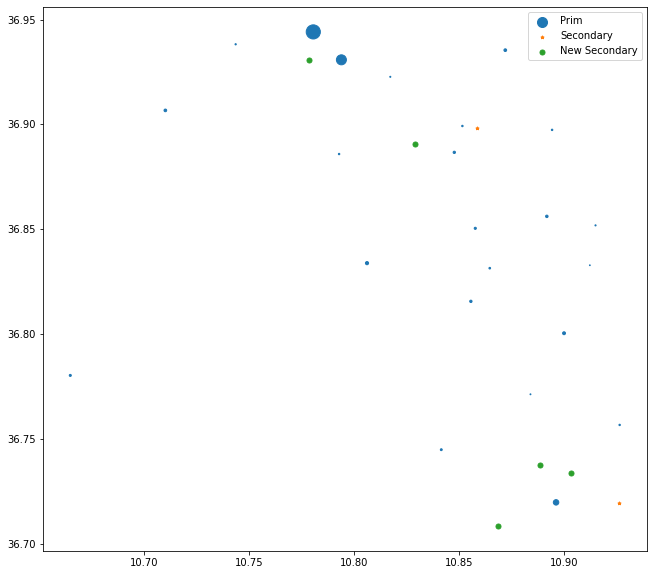

In [37]:
plt.figure(figsize=(15, 10))
plt.scatter(df_prim_loc[:, 0], df_prim_loc[:, 1], s=df_prim_enroll/100, label="Prim") # s gives size
plt.scatter(df_sec_loc[:, 0], df_sec_loc[:, 1], s = 10, marker="*", label="Secondary") # stars for supermarkets
plt.scatter(best_solution[:, 0], best_solution[:, 1], s = 25, marker="o", label="New Secondary") # stars for supermarkets
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

In [38]:
ff = np.array_split(es.result[0],5)
enrol = 0
for i in ff:
    dist = np.min(haversine_vector(df_prim_loc, i, Unit.KILOMETERS, comb=True))
    enrol_index = np.argmin(haversine_vector(i, df_prim_loc, Unit.KILOMETERS, comb=True))
    enroly = shape(dist, (df_prim_enroll[enrol_index]*.79901))
    enrol += enroly
    print('Distance: ', round(dist,2), '\n',
          'Index: ', enrol_index,'\n', 
          'Shaped Enrollment: ',int(enroly),'\n',
          'Accumulative Enrollment: ', int(enrol),'\n',
          'Coordinates: ', i)

Distance:  1.74 
 Index:  8 
 Shaped Enrollment:  2397 
 Accumulative Enrollment:  2397 
 Coordinates:  [10.90330635 36.73411476]
Distance:  2.15 
 Index:  8 
 Shaped Enrollment:  2278 
 Accumulative Enrollment:  4675 
 Coordinates:  [10.88848855 36.73790747]
Distance:  1.5 
 Index:  0 
 Shaped Enrollment:  15980 
 Accumulative Enrollment:  20655 
 Coordinates:  [10.77865914 36.93047936]
Distance:  3.32 
 Index:  8 
 Shaped Enrollment:  1345 
 Accumulative Enrollment:  22000 
 Coordinates:  [10.86861454 36.70859255]
Distance:  2.15 
 Index:  7 
 Shaped Enrollment:  410 
 Accumulative Enrollment:  22410 
 Coordinates:  [10.82885283 36.89057344]


In [39]:
enrol

22410.0

In [40]:
ff = np.array_split(es.result[0],5)
x = np.array(np.array_split(np.append(df_sec_loc, ff),len(df_sec_loc)+5)) # add proposed locations to current list of secondary schools
enrol = 0

distance = np.min(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)
enrollment = df_prim_enroll[np.argmin(haversine_vector(df_prim_loc, x, Unit.KILOMETERS, comb=True), axis=0)]
enrollment = enrollment*.79901 # by enrollment proportion
enrollment = shape(distance,enrollment)
enrol = np.sum(enrollment)
print(int(enrol))

4329


In [41]:
distance

array([ 1.50339279,  6.95543258,  4.32832206,  8.05390253,  5.91696689,
        6.68271563,  8.70483452,  1.73032317,  1.73665092,  5.22039308,
       20.71577983,  4.98307384,  7.32832395,  4.00496738,  0.756862  ,
        4.03023232,  3.58379993,  1.70618788,  3.98859298,  8.08828689,
        3.73653704,  3.68959635,  9.33020509])

In [42]:
enrollment

array([495.,   0., 152.,   0.,   0.,   0.,   0., 677., 583.,   0.,   0.,
         5.,   0., 224., 677., 144., 275., 495., 167.,   0., 187., 248.,
         0.])

In [43]:
# Total new secondary enrolment with new 5 schools
abs(sum(df_sec_enroll)+int(enrol))

7584

In [44]:
sum(df_sec_enroll)

3255

In [45]:
enrol

4329.0

In [46]:
np.sum(df_sec_enroll)

3255